Plot Network Topology

In [79]:
from dotenv import load_dotenv
import pandapower.plotting as plot
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import numpy as np
import os
from sqlalchemy import create_engine, text
import networkx as nx

load_dotenv()

# Create SQLAlchemy engine
db_url = f"postgresql://{os.getenv('POSTGRES_DB_USER', 'root')}:{os.getenv('POSTGRES_DB_PASSWORD', 'skamasfrevrest')}@{os.getenv('POSTGRES_DB_HOST', '103.0.2.7')}:{os.getenv('POSTGRES_DB_PORT', '5433')}/{os.getenv('POSTGRES_DB_NAME', 'duilio')}"
engine = create_engine(db_url)
conn = engine.connect()

# Função para plotar CDF com sombra
def plot_cdf_with_shadow(data_mean, data_hi, data_lo, label):
    sorted_data_mean = np.sort(data_mean)
    #cdf = 100*np.arange(len(sorted_data_mean)) / float(len(sorted_data_mean))
    cdf = np.arange(1, len(sorted_data_mean) + 1) / len(sorted_data_mean) * 100

    
    sorted_data_hi = np.sort(data_hi)
    sorted_data_lo = np.sort(data_lo)
    
    plt.plot(sorted_data_mean, cdf, label=label)
    plt.fill_betweenx(cdf, sorted_data_lo, sorted_data_hi, alpha=0.2)

def get_timeseries_statistics(conn, simulation_id, element_type=None, element_idxs=None, output_name=None):
        # Build dynamic WHERE clauses
        where_clauses = ["v.simulation_output_id = :simulation_id"]
        params = {"simulation_id": simulation_id}

        if element_type is not None:
                where_clauses.append("v.extra_info ->> 'element_type' LIKE :element_type")
                params["element_type"] = element_type

        if element_idxs is not None:
                # Ensure element_idxs is a list for ANY clause
                if isinstance(element_idxs, int):
                        element_idxs = [element_idxs]
                where_clauses.append("(v.extra_info ->> 'element_index')::int = ANY(:element_idxs)")
                params["element_idxs"] = element_idxs

        if output_name is not None:
                where_clauses.append("v.extra_info ->> 'output' LIKE :output_name")
                params["output_name"] = output_name

        where_sql = " AND ".join(where_clauses)

        query = text(f"""
                WITH bus_variables AS (
                SELECT v.variable_id, v.variable_name, v.extra_info
                FROM building_power.variable v
                WHERE {where_sql}
                ),
                per_variable AS (
                SELECT
                        ot.variable_id,
                        average(ot.quantity) AS avg_quantity,
                        percentile(ot.quantity, 0.95) AS p95_quantity,
                        percentile(ot.quantity, 0.05) AS p05_quantity
                FROM building_power.output_timeseries ot
                JOIN bus_variables bv ON ot.variable_id = bv.variable_id
                GROUP BY ot.variable_id
                )
                SELECT
                AVG(avg_quantity) AS mean_quantity,
                AVG(p95_quantity) AS mean_p95_quantity,
                AVG(p05_quantity) AS mean_p05_quantity
                FROM per_variable;""")
        
        df = pd.read_sql_query(
                query,
                conn,
                params=params
        )
        return df

import pandas as pd
from sqlalchemy import text

from sqlalchemy import text, Engine, Connection

def explain_get_timeseries_data(
    conn: Engine | Connection,
    simulation_id: int,
    element_type: str = None,
    element_idxs: list = None,
    output_name: str = None
):
        """
        Returns EXPLAIN ANALYZE for the optimized timeseries aggregation.
        simulation_id is required. Other filters are optional.
        """

        if simulation_id is None:
                raise ValueError("simulation_id cannot be None")

        where_clauses = ["v.simulation_output_id = %(simulation_id)s"]
        params = {"simulation_id": simulation_id}

        # Optional filter: output_name (LIKE)
        if output_name is not None:
                where_clauses.append("(v.extra_info ->> 'output') LIKE %(output_name)s")
                params["output_name"] = output_name

        # Optional filter: element_type (LIKE)
        if element_type is not None:
                where_clauses.append("(v.extra_info ->> 'element_type') LIKE %(element_type)s")
                params["element_type"] = element_type

        # Optional filter: element_idxs
        if element_idxs is not None:
                if isinstance(element_idxs, int):
                        element_idxs = [element_idxs]
                        where_clauses.append("((v.extra_info ->> 'element_index')::int = ANY(%(element_idxs)s))")
                        params["element_idxs"] = element_idxs
                        where_sql = " AND ".join(where_clauses)

        sql = f"""
                EXPLAIN (ANALYZE, BUFFERS, VERBOSE)
                SELECT
                ot.ts AS bucket,
                SUM(ot.quantity) AS total_quantity
                FROM building_power.output_timeseries ot
                JOIN building_power.variable v
                ON v.variable_id = ot.variable_id
                WHERE {where_clauses}
                GROUP BY ot.ts
                ORDER BY ot.ts;
                """

        # Pick connection type
        if isinstance(conn, Connection):
                connection = conn
        else:
                connection = conn.connect()
        
        # Execute
        result = connection.execute(text(sql), params).fetchall()

        # If we opened the connection, close it
        if isinstance(conn, Engine):
                connection.close()

        # Format output
        return "\n".join(r[0] for r in result)






def get_timeseries_data(conn, simulation_id, element_type=None, element_idxs=None, output_name=None):
        """
        Retrieves aggregated timeseries data using the optimized Continuous Aggregate.
        Note: Returns SUM(power) as total_power, not SUM(AVG(power)).
        """
        # Build dynamic WHERE clauses
        
        # Filters applied to the variable table (v)
        where_clauses = ["v.simulation_output_id = :simulation_id"]
        params = {"simulation_id": simulation_id}

        if element_type is not None:
                where_clauses.append("(v.extra_info ->> 'element_type') LIKE :element_type")
                params["element_type"] = element_type

        if element_idxs is not None:
                # Ensure element_idxs is a list for ANY clause
                if isinstance(element_idxs, int):
                        element_idxs = [element_idxs]
                where_clauses.append("((v.extra_info ->> 'element_index')::int = ANY(:element_idxs))")
                params["element_idxs"] = element_idxs

        if output_name is not None:
                where_clauses.append("(v.extra_info ->> 'output') LIKE :output_name")
                params["output_name"] = output_name

        where_sql = " AND ".join(where_clauses)

        query = text(f"""
                WITH 
                bus_variables AS (
                        SELECT v.variable_id
                        FROM building_power.variable v
                        WHERE {where_sql}
                )                 
                SELECT
                        agg.bucket,
                        SUM(agg.sum_quantity) AS total_quantity
                FROM
                       building_power.power_15min_by_variable agg                
                WHERE agg.variable_id IN (SELECT variable_id FROM bus_variables)
                GROUP BY
                agg.bucket
                ORDER BY
                agg.bucket;""")
        
        df = pd.read_sql_query(
                query,
                conn,
                params=params
        )
        return df

In [80]:
from create_random_network import load_network_from_database
from sqlalchemy import text

test_name = 'debug_random'

def get_last_simulation_output_id(test_name, conn):
    """Get the last simulation_output_id for a given test_name"""
   
    # Query to find the most recent simulation with matching test_name
    query = text("""
        SELECT simulation_output_id, parameters
        FROM building_power.simulation_outputs 
        WHERE parameters ->> 'name' = :test_name
        ORDER BY started_at DESC 
        LIMIT 1
    """)
    
    result = conn.execute(query, {"test_name": test_name}).fetchone()
    
    if result:
        return result[0], result[1]
    else:
        return None, None

# Get the last simulation_output_id for the current test_name
simulation_output_id, simulation_parameters = get_last_simulation_output_id(test_name, conn)

if simulation_output_id:
    print(f"Last simulation_output_id for test_name '{test_name}': {simulation_output_id}")
    # Create conn_parameters dict for load_network_from_database
    conn_parameters = {
        "dbname": os.getenv("POSTGRES_DB_NAME", "duilio"),
        "user": os.getenv("POSTGRES_DB_USER", "root"),
        "password": os.getenv("POSTGRES_DB_PASSWORD", "skamasfrevrest"),
        "host": os.getenv("POSTGRES_DB_HOST", "103.0.2.7"),
        "port": int(os.getenv("POSTGRES_DB_PORT", "5433"))
    }
    pandapower_grid_id, net, graph = load_network_from_database(conn_parameters, simulation_parameters['network_id'])
else:
    print(f"No simulation found for test_name '{test_name}'")

Last simulation_output_id for test_name 'debug_random': 195
Loaded network 'very_small_test_network' with 9 buses and 8 connections


/usr/local/lib/python3.13/site-packages/pandapower/sql_io.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(np.nan)
/usr/local/lib/python3.13/site-packages/pandapower/sql_io.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(np.nan)
/usr/local/lib/python3.13/site-packages/pandapower/sql_io.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('f

Plot the simulated network

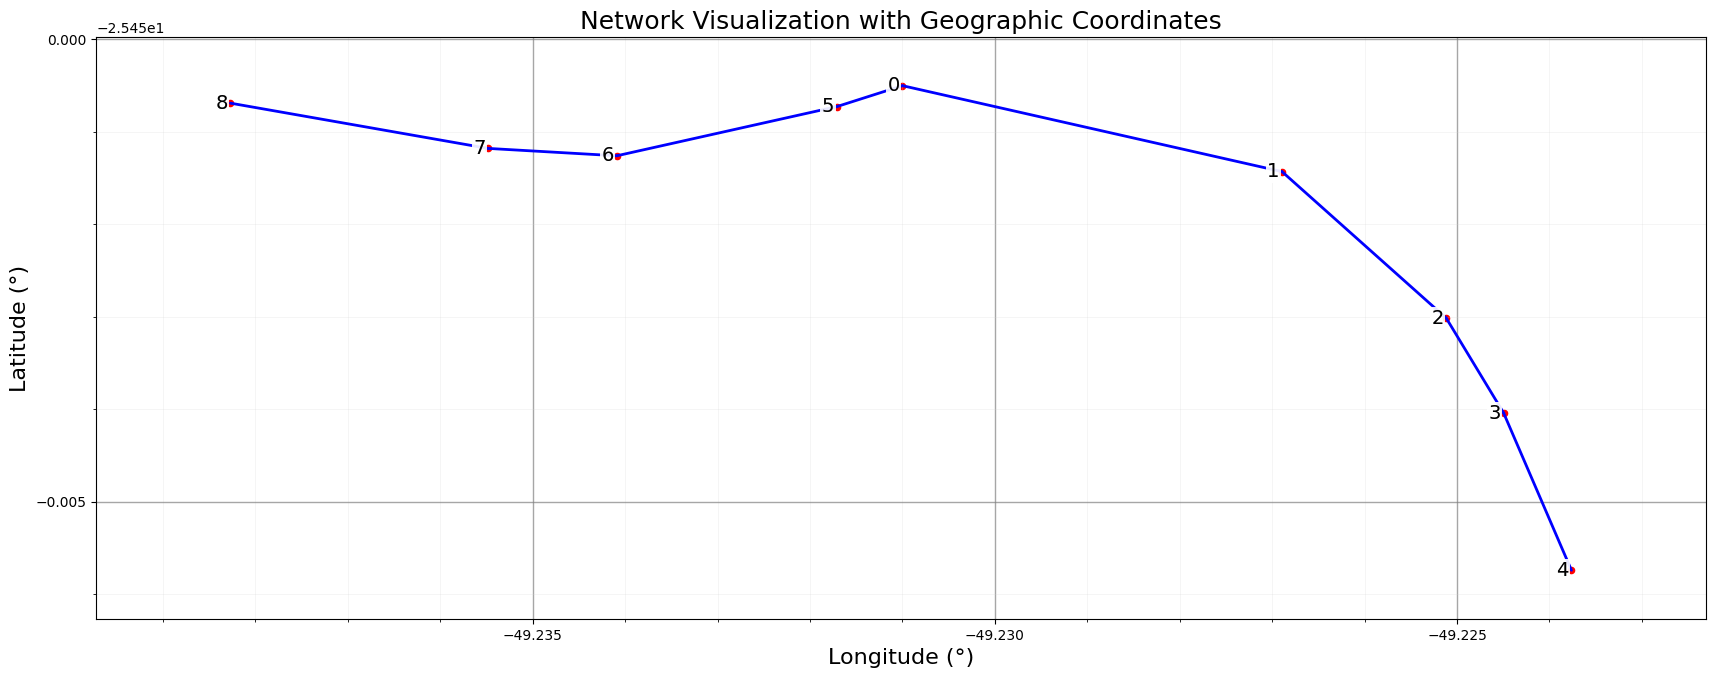

In [81]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas
from shapely.geometry import Point, LineString

# 1. Extract bus coordinates
bus_points = [Point(row['x'], row['y']) if not pd.isna(row['x']) and not pd.isna(row['y']) else None 
             for idx, row in net.bus_geodata.iterrows()]

# 2. Create GeoSeries
bus_geo_series = geopandas.GeoSeries(bus_points)

# 3. Create lines from graph edges
line_geometries = []
for u, v, _ in graph.edges(data=True):
    if u < len(bus_points) and v < len(bus_points) and bus_points[u] and bus_points[v]:
        line_geometries.append(LineString([bus_points[u], bus_points[v]]))
    else:
        print(f"Warning: Skipping line between bus {u} and {v}")

# 4. Create GeoDataFrame
line_geo_df = geopandas.GeoDataFrame({'geometry': line_geometries})

# 5. Create figure with large size
fig, ax = plt.subplots(figsize=(20, 20))

# Plot network
line_geo_df.plot(ax=ax, color='blue', linewidth=2)
bus_geo_series.plot(ax=ax, color='red', markersize=20)

# Get bounds
valid_points = [p for p in bus_points if p]
if valid_points:
    min_x = min(p.x for p in valid_points)
    max_x = max(p.x for p in valid_points)
    min_y = min(p.y for p in valid_points)
    max_y = max(p.y for p in valid_points)
    
    # Add padding
    pad_x = (max_x - min_x) * 0.1
    pad_y = (max_y - min_y) * 0.1
    min_x -= pad_x
    max_x += pad_x
    min_y -= pad_y
    max_y += pad_y
    
    # Check if coordinates are likely lat/lon (small values around -180 to 180 for longitude and -90 to 90 for latitude)
    is_latlon = (min_x > -180 and max_x < 180 and min_y > -90 and max_y < 90)
    
    if is_latlon:
        # For lat/lon coordinates, use 0.001° grid (approx. 111m at equator) and 0.005° labels
        # 0.001° is roughly 111 meters at the equator
        minor_ticks_x = np.arange(np.floor(min_x/0.001)*0.001, np.ceil(max_x/0.001)*0.001, 0.001)
        minor_ticks_y = np.arange(np.floor(min_y/0.001)*0.001, np.ceil(max_y/0.001)*0.001, 0.001)
        major_ticks_x = np.arange(np.floor(min_x/0.005)*0.005, np.ceil(max_x/0.005)*0.005, 0.005)
        major_ticks_y = np.arange(np.floor(min_y/0.005)*0.005, np.ceil(max_y/0.005)*0.005, 0.005)
        
        # Set ticks and grid
        ax.set_xticks(major_ticks_x)
        ax.set_yticks(major_ticks_y)
        ax.set_xticks(minor_ticks_x, minor=True)
        ax.set_yticks(minor_ticks_y, minor=True)
        
        # Grid styling
        ax.grid(which='major', color='gray', linestyle='-', linewidth=1, alpha=0.7)
        ax.grid(which='minor', color='lightgray', linestyle='-', linewidth=0.5, alpha=0.3)
        
        # Add coordinate labels only for major ticks (with less frequent labels for readability)
        # Show fewer labels to avoid overcrowding
        # for i, x in enumerate(major_ticks_x):
        #     if i % 2 == 0:  # Only show every other label
        #         ax.text(x, min_y - pad_y*0.3, f'{x:.4f}°', 
        #                ha='center', va='top', fontsize=10, color='black')
        # for i, y in enumerate(major_ticks_y):
        #     if i % 2 == 0:  # Only show every other label
        #         ax.text(min_x - pad_x*0.3, y, f'{y:.4f}°', 
        #                ha='right', va='center', fontsize=10, color='black')
                       
        plot_title = "Network Visualization with Geographic Coordinates"
        x_label = "Longitude (°)"
        y_label = "Latitude (°)"
    else:
        # Assume meters format (original code)
        # Create 50m grid (minor) and 100m ticks (major)
        major_ticks = np.arange(np.floor(min_x/100)*100, np.ceil(max_x/100)*100, 100)
        minor_ticks = np.arange(np.floor(min_x/50)*50, np.ceil(max_x/50)*50, 50)
        
        # Set ticks and grid
        ax.set_xticks(major_ticks)
        ax.set_yticks(major_ticks)
        ax.set_xticks(minor_ticks, minor=True)
        ax.set_yticks(minor_ticks, minor=True)
        
        # Grid styling - major (100m) is bolder
        ax.grid(which='major', color='gray', linestyle='-', linewidth=1, alpha=0.7)
        ax.grid(which='minor', color='lightgray', linestyle='-', linewidth=0.5, alpha=0.3)
        
        # Add coordinate labels only for major ticks
        for x in major_ticks:
            ax.text(x, min_y - pad_y*0.3, f'{x:.0f}m', 
                   ha='center', va='top', fontsize=12, color='black')
        for y in major_ticks:
            ax.text(min_x - pad_x*0.3, y, f'{y:.0f}m', 
                   ha='right', va='center', fontsize=12, color='black')
                   
        plot_title = "Network Visualization with 50m Grid (100m Labels)"
        x_label = "X Coordinate (m)"
        y_label = "Y Coordinate (m)"

# Annotate buses

# Set axis limits to only span the network area (with a small padding)
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)

# Make the plot narrower and shorter
fig.set_size_inches(17, 17)

for idx, point in enumerate(bus_geo_series):
    if point:
        ax.text(point.x - pad_x*0.02, point.y, str(idx),
               fontsize=14, color='black', ha='right', va='center',
               bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))
for idx, point in enumerate(bus_geo_series):
    if point:
        ax.text(point.x - pad_x*0.02, point.y, str(idx),
               fontsize=14, color='black', ha='right', va='center',
               bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

# Set the plot title using ax.set_title instead of plt.title to avoid layout issues
ax.set_title(plot_title, fontsize=18)

# Remove extra whitespace around the plot by tightening the layout
plt.tight_layout()
plt.xlabel(x_label, fontsize=16)
plt.ylabel(y_label, fontsize=16)
#ax.set_aspect('equal')

# Save as PDF
plt.savefig('network_visualization_clean_grid.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

Plot network power

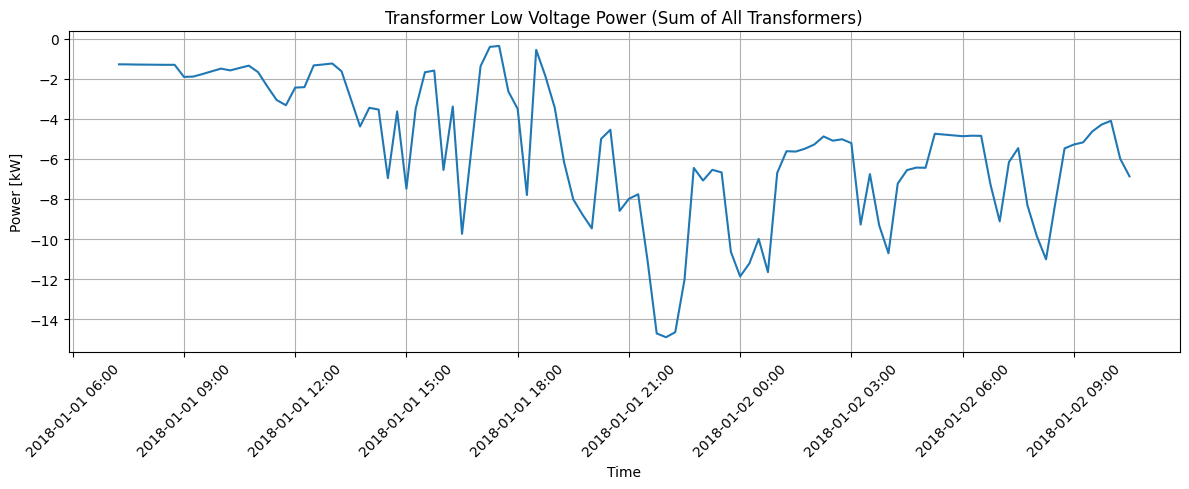

In [82]:
# Query transformer low voltage power time series for the last simulation
df_trafo_lv = get_timeseries_data(
    conn,
    simulation_output_id,
    element_type='transformer',
    output_name='P_%_lv[MW]'
)

if df_trafo_lv.empty:
    print("No transformer low voltage power data found for this simulation.")
else:
    df_trafo_lv['bucket'] = pd.to_datetime(df_trafo_lv['bucket'])
    plt.figure(figsize=(12, 5))
    plt.plot(df_trafo_lv['bucket'], df_trafo_lv['total_quantity'] * 1000)
    plt.title('Transformer Low Voltage Power (Sum of All Transformers)')
    plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.xticks(rotation=45)
    plt.xlabel('Time')
    plt.ylabel('Power [kW]')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Power Generation/Use

No data found for State of Charge


/tmp/ipykernel_3331464/2599303495.py:130: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc='upper right')


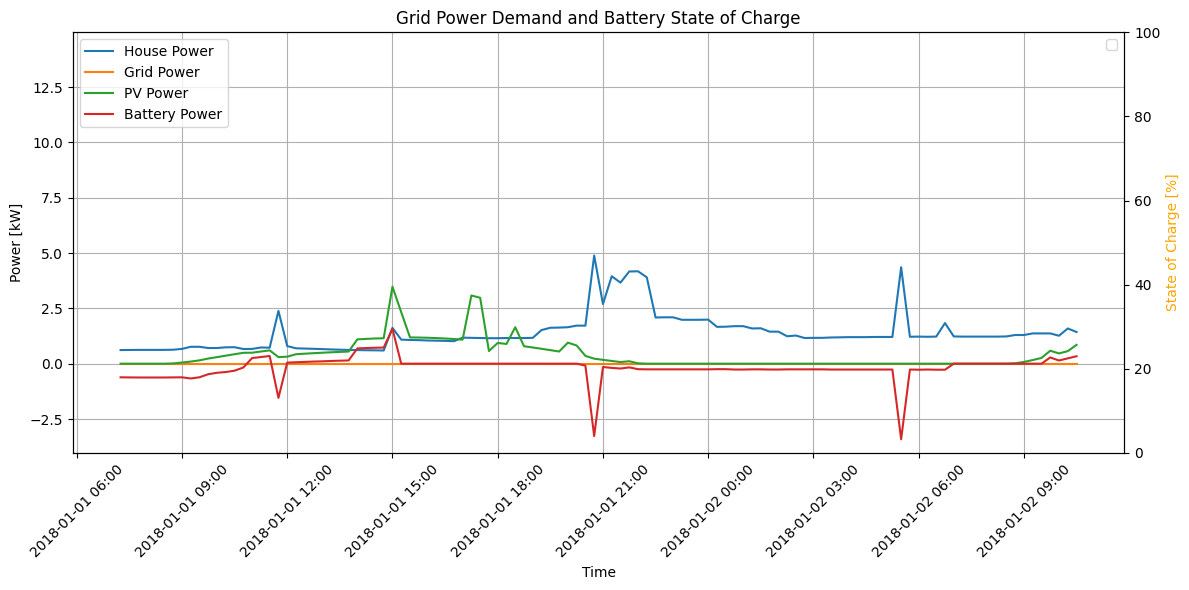

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data for CSV export
csv_df = pd.DataFrame()
lv_buses = []
# --- Step 1: Collect all bus descendants from trafos ---
for idx, trafo in net.trafo.iterrows():    
    lv_buses.extend(list(nx.descendants(graph,trafo['lv_bus'])))

# Remove duplicates
lv_buses = list(set(lv_buses))  

energy_outputs = [
    ('Power[kW]', 'House Power', 1),
    ('P_%_load[MW]', 'Grid Power', 1000),    
    ('PVPowerGeneration[MW]', 'PV Power', 1000),
    ('BatteryPower[MW]', 'Battery Power', 1000),
]
# Create a second y-axis for SOC
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()


# Plot power data on the left y-axis
for output_name, label, multiplier in energy_outputs:
    # print(explain_get_timeseries_data(
    #     conn,
    #     simulation_output_id,
    #     output_name=output_name,
    #     element_idxs=lv_buses
    # ))

    df_energy = get_timeseries_data(
        conn,
        simulation_output_id,
        output_name=output_name,
        element_idxs=lv_buses
    )
    if not df_energy.empty:
        df_energy['bucket'] = pd.to_datetime(df_energy['bucket'])
        ax1.plot(df_energy['bucket'], df_energy['total_quantity'] * multiplier, label=label)
        # Append to CSV DataFrame
        csv_df_temp = df_energy.copy()
        csv_df_temp.rename(columns={'total_quantity': label.replace(" ", "_")}, inplace=True)
        if csv_df.empty:
            csv_df = csv_df_temp
        else:
            csv_df = pd.merge(csv_df, csv_df_temp, on='bucket', how='outer')
    else:
        print(f"No data found for {label}")

# Get the overall storage capacity
total_capacity = 0
for bus in lv_buses:
    if 'household_params' in graph.nodes[bus]:
        total_capacity += graph.nodes[bus]['household_params'].get('StorageCapacity_MWh', 0)


# print(explain_get_timeseries_data(
#                             conn,
#                             simulation_output_id,
#                             output_name='SOC[MWh]',
#                             element_idxs=lv_buses
#                             )
#      )

# Plot SOC on the right y-axis
df_soc = get_timeseries_data(
    conn,
    simulation_output_id,
    output_name='SOC[MWh]',
    element_idxs=lv_buses
)
if not df_soc.empty and total_capacity > 0:
    df_soc['bucket'] = pd.to_datetime(df_soc['bucket'])
    ax2.plot(df_soc['bucket'], 100*df_soc['total_quantity']/total_capacity, color='orange', label='State of Charge')
    # Append to CSV DataFrame
    csv_df_temp = df_soc.copy()
    csv_df_temp['total_quantity'] = 100*csv_df_temp['total_quantity']/total_capacity
    csv_df_temp.rename(columns={'total_quantity': 'State_of_Charge_%'}, inplace=True)
    if csv_df.empty:
        csv_df = csv_df_temp
    else:
        csv_df = pd.merge(csv_df, csv_df_temp, on='bucket', how='outer')
else:
    print("No data found for State of Charge")

# Configure axes
ax1.set_xlabel('Time')
ax1.set_ylabel('Power [kW]', color='black')
ax2.set_ylabel('State of Charge [%]', color='orange')
ax2.set_ylim(0, 100)
# Adjust SOC y-axis to show full range with some padding
soc_min = df_soc['total_quantity'].min()
soc_max = df_soc['total_quantity'].max()
soc_range = soc_max - soc_min
padding = soc_range * 0.1 if soc_range > 0 else 5
# Calculate power range for aligning zeros
power_values = []
for output_name, label, multiplier in energy_outputs:
    df_energy = get_timeseries_data(conn, simulation_output_id, output_name=output_name)
    if not df_energy.empty:
        power_values.extend((df_energy['total_quantity'] * multiplier).tolist())

if power_values:
    min_power = min(power_values)
    max_power = max(power_values)
    if max_power > min_power:
        rel_zero = (0 - min_power) / (max_power - min_power)
        ylim_min2 = 0 - rel_zero * 100
        ylim_max2 = 100 - rel_zero * 100
        ax1.set_ylim(min_power, max_power)
        ax2.set_ylim(ylim_min2, ylim_max2)
    else:
        ax1.set_ylim(min_power*1.05, max_power*1.05)
        ax2.set_ylim(0, 100)
else:
    ax1.set_ylim(0, 100)
    ax2.set_ylim(0, 100)
# Set both axes to start from zero
#ax1.set_ylim(0, None)  # Power axis starts from zero
ax2.set_ylim(0, 100)   # SOC axis from 0 to 100%
# Format x-axis
ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M'))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')


ax1.grid(True)
plt.title('Grid Power Demand and Battery State of Charge')
plt.tight_layout()
plt.show()

if not csv_df.empty:
    csv_df.to_csv('power_and_soc_results.csv', index=False)




Create a file with all variables

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import text

# Step 1: Query all variables from building_power.variable table using extra_info->>'output'
query_variables = """
SELECT 
    variable_name,
    v.extra_info->>'element_index' as idx,
    v.extra_info->>'output' as output_name,
    v.unit
FROM building_power.variable v
WHERE v.simulation_output_id = :simulation_output_id
    AND v.extra_info->>'output' IS NOT NULL
ORDER BY v.extra_info->>'output'
"""

variables_df = pd.read_sql_query(text(query_variables), conn, params={'simulation_output_id': simulation_output_id})
print(f"Found {len(variables_df)} unique variables:")
#print(variables_df)

# Step 2: Build comprehensive dataframe with all variables
csv_df = pd.DataFrame()
lv_buses = []

# Step 3: Fetch data for each variable and merge into one dataframe
for idx, row in variables_df.iterrows():
    column_name = row['variable_name']
    output_name = row['output_name']
    unit = row['unit']
    idx = int(row['idx'])
    
    #print(f"\nFetching data for: {column_name} {output_name} ({unit})")
    
    try:
        df_var = get_timeseries_data(
            conn,
            simulation_output_id,
            output_name=output_name,
            element_idxs=idx 
        )
        
        if not df_var.empty:
            df_var['bucket'] = pd.to_datetime(df_var['bucket'])
            
            # Create a clean column name            
            df_var_clean = df_var[['bucket', 'total_quantity']].copy()
            df_var_clean.rename(columns={'total_quantity': column_name}, inplace=True)
            
            # Merge with main dataframe
            if csv_df.empty:
                csv_df = df_var_clean
            else:
                csv_df = pd.merge(csv_df, df_var_clean, on='bucket', how='outer')
            
            #print(f"  ✓ Added {col_name} ({len(df_var)} records)")
        else:
            print(f"  ✗ No data found for {output_name}")
    except Exception as e:
        print(f"  ✗ Error fetching {output_name}: {str(e)}")

# Step 4: Save comprehensive dataframe to CSV
if not csv_df.empty:
    # Sort by timestamp
    csv_df = csv_df.sort_values('bucket').reset_index(drop=True)
    
    print(f"\n\nFinal dataframe shape: {csv_df.shape}")
    print(f"Date range: {csv_df['bucket'].min()} to {csv_df['bucket'].max()}")
    print(f"\nColumns: {list(csv_df.columns)}")
    
    csv_df.to_csv('all_simulation_data.csv', index=False)
    print("\n✓ Data saved to 'all_simulation_data.csv'")    
    
else:
    print("No data was collected!")




Found 152 unique variables:




Final dataframe shape: (110, 153)
Date range: 2018-01-01 07:15:00+00:00 to 2018-01-02 10:30:00+00:00

Columns: ['bucket', 'HouseholdProducer-0.HouseholdProducer_2-BatteryPower[MW]', 'HouseholdProducer-0.HouseholdProducer_3-BatteryPower[MW]', 'HouseholdProducer-0.HouseholdProducer_0-BatteryPower[MW]', 'HouseholdProducer-0.HouseholdProducer_1-BatteryPower[MW]', 'SolarIrradiation-0.SolarIrradiation_3-DNI[W/m2]', 'SolarIrradiation-0.SolarIrradiation_2-DNI[W/m2]', 'SolarIrradiation-0.SolarIrradiation_0-DNI[W/m2]', 'SolarIrradiation-0.SolarIrradiation_1-DNI[W/m2]', 'Pandapower-0.Line-4-I_a_from[kA]', 'Pandapower-0.Line-3-I_a_from[kA]', 'Pandapower-0.Line-1-I_a_from[kA]', 'Pandapower-0.Line-0-I_a_from[kA]', 'Pandapower-0.Line-5-I_a_from[kA]', 'Pandapower-0.Line-2-I_a_from[kA]', 'Pandapower-0.Line-3-I_b_from[kA]', 'Pandapower-0.Line-2-I_b_from[kA]', 'Pandapower-0.Line-5-I_b_from[kA]', 'Pandapower-0.Line-4-I_b_from[kA]', 'Pandapower-0.Line-0-I_b_from[kA]', 'Pandapower-0.Line-1-I_b_from[kA]', 

Test data

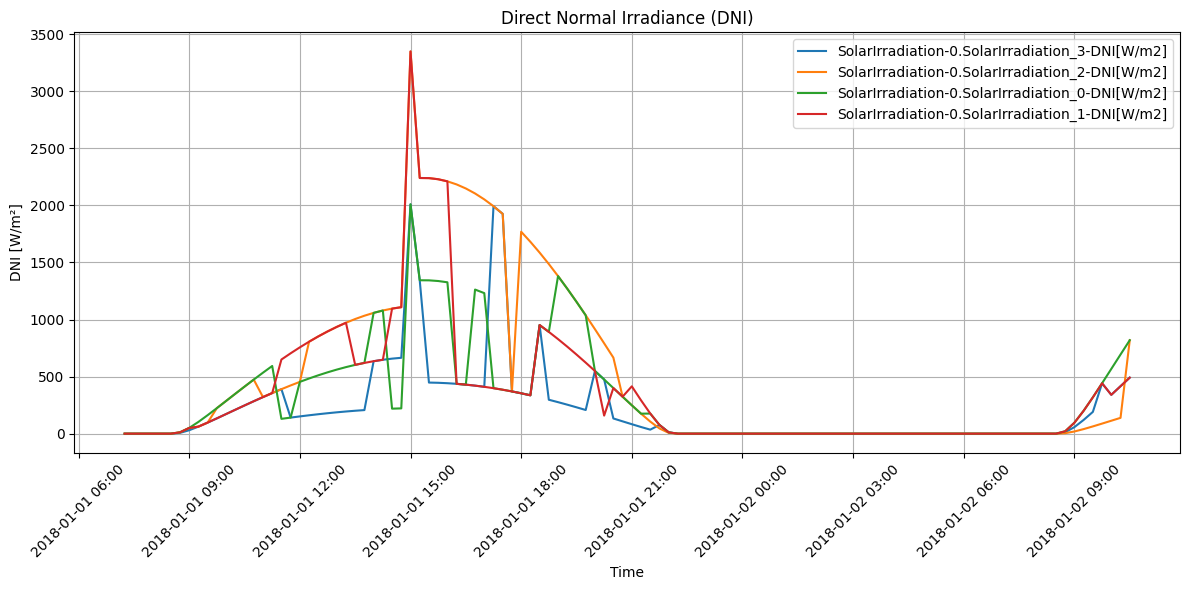

In [85]:
# Filter columns that end with 'DNI[W/m2]'
dni_columns = [col for col in csv_df.columns if col.endswith('DNI[W/m2]')]

if dni_columns:
    plt.figure(figsize=(12, 6))
    for col in dni_columns:
        plt.plot(csv_df['bucket'], csv_df[col], label=col)
    
    plt.xlabel('Time')
    plt.ylabel('DNI [W/m²]')
    plt.title('Direct Normal Irradiance (DNI)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.tight_layout()
    plt.show()
else:
    print("No columns ending with 'DNI[W/m2]' found in the dataframe")